# Prototypage projet gpgpu

### Import libraries and data

In [25]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import skimage
import skimage.io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
image_rgb = skimage.io.imread('data/barcode-00-01.jpg')

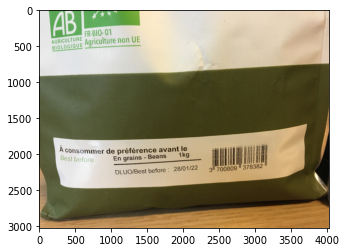

In [4]:
plt.imshow(image_rgb)

In [5]:
row, col, rgb = image_rgb.shape
row, col, rgb

(3024, 4032, 3)

In [6]:
# Image can be nicely divided in 16x16 patches
row / 16, col / 16

(189.0, 252.0)

In [7]:
image = rgb2gray(image_rgb)

# Generate the 16x16 patches / tiles

In [8]:
def generateTiles(image, tile_size=16):
    row, col = image.shape
    tiles = []
    for y in range(row // tile_size):
        line_tiles = []
        for x in range(col // tile_size):
            y_min, y_max = y * tile_size, (y + 1) * tile_size 
            x_min, x_max = x * tile_size, (x + 1) * tile_size 
            line_tiles.append(image[y_min:y_max, x_min:x_max])
        tiles.append(line_tiles)
    return np.array(tiles)

In [9]:
%time tiles = generateTiles(image)
tiles.shape, tiles.dtype

CPU times: user 320 ms, sys: 917 ms, total: 1.24 s
Wall time: 180 ms


((189, 252, 16, 16), dtype('float64'))

### For each patch / tile, extract every pixels 3x3 kernel neighbours feature vector

In [10]:
def getTileLocalPattern(tile):
    if tile.shape != (16, 16):
        raise Exception("Tile has invalid shape")

    res = []
    padded = np.pad(tile, pad_width=1, mode='constant', constant_values=0)

    for y in range(1, tile.shape[0] + 1):
        for x in range(1, tile.shape[1] + 1):
            # threshold to apply to neighbours
            threshold = padded[y, x]
            # get tile in 1d without current element
            y_min, y_max, x_min, x_max = y-1, y+1, x-1, x+1
            neighs = padded[y_min:y_max+1, x_min:x_max+1]
            neighs = neighs.reshape(-1)
            neighs = np.delete(neighs, neighs.size // 2)
            # apply filter
            res.append((neighs >= threshold).astype('uint8'))

    return np.array(res)

In [11]:
%%time
tile_pattern = getTileLocalPattern(tiles[0][0])

CPU times: user 1.55 ms, sys: 890 µs, total: 2.44 ms
Wall time: 2.12 ms


### For every patch's feature vector,  convert in texton

In [12]:
def getPatternHistogram(tile_pattern):
    return np.apply_along_axis(lambda arr: sum([val << i for i, val in enumerate(arr)]), 1, tile_pattern)

In [13]:
%%time
histo = getPatternHistogram(tile_pattern)

CPU times: user 4.11 ms, sys: 1.06 ms, total: 5.17 ms
Wall time: 5.18 ms


### Show histogram

(array([[254.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 26.,  25.,  26.,  25.,  26.,  25.,  26.,  25.,  26.,  26.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 2 BarContainer objects>)

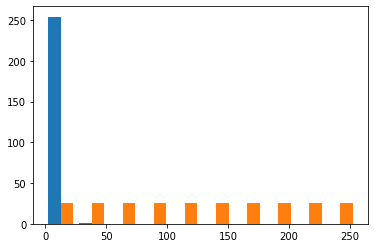

In [14]:
plt.hist(np.histogram(histo, bins=255))

### Apply the process to every tile and extract a tile feature map

In [15]:
def getTilesFeatures(tiles):
    res = []
    for y in range(tiles.shape[0]):
        for x in range(tiles.shape[1]):
            tile = tiles[y,x]
            localPattern = getTileLocalPattern(tile)
            histogram = getPatternHistogram(localPattern)
            res.append(histogram)

    return np.array(res)

In [16]:
features = getTilesFeatures(tiles)

In [17]:
features.shape

(47628, 256)

## Make prediction on extracted data

In [57]:
def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)  # take n_values values between 0 and 1 (evenly spaced)
    rng = np.random.default_rng(3)  # get a RNG with a specific seed
    samples = rng.permutation(samples)  # shuffle our values
    colors = cm.hsv(samples, alpha=None, bytes=True)  # get corresponding colors from the HSV color map
    return colors[...,:3]  # remove alpha channel and return

In [58]:
features_src = features.copy()

### Use MiniBatchKmeans

In [64]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler

features_scaled = StandardScaler().fit_transform(features)

n_clusters = 16
clusterer = MiniBatchKMeans(n_clusters, random_state=3)
labels = clusterer.fit_predict(features_scaled)

In [65]:
predicted = labels.reshape(np.array(image.shape[:2]) // 16)
color_lut = random_lut(clusterer.n_clusters)
predicted_rgb = color_lut[predicted]

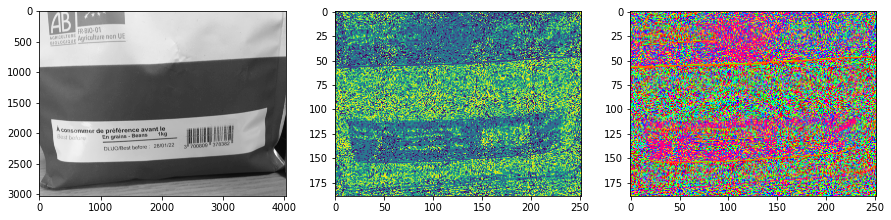

In [66]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.imshow(predicted)
plt.subplot(133)
plt.imshow(predicted_rgb)